In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
!pip install numpy
!pip install matplotlib
!pip install sklearn
!pip install torch
!pip install nvidia-ml-py3 beautifulsoup4 fastprogress
!pip install bottleneck dataclasses

In [150]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from fastai.tabular import *

In [23]:
# Download 'Blue book Bulldozer' dataset from Kallgle
data_path = 'data/bulldozer/TrainAndValid.csv'

In [28]:
df_raw = pd.read_csv(data_path, low_memory=False, parse_dates=['saledate'])

In [42]:
df = df_raw.copy()
procs = [FillMissing, Categorify]
dep_var = 'SalePrice'
cat_names = ['UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls']

df.SalePrice = np.log(df.SalePrice)
df = add_datepart(df, 'saledate')
valid_idx = range(len(df)-12000, len(df))

In [44]:
data = TabularDataBunch.from_df(data_path, df, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names)
print(data.train_ds.cont_names) 

['MachineHoursCurrentMeter', 'saleYear', 'saleIs_year_end', 'saleElapsed', 'SalesID', 'saleDayofyear', 'datasource', 'ModelID', 'saleDayofweek', 'saleMonth', 'saleIs_year_start', 'MachineID', 'auctioneerID', 'saleIs_quarter_end', 'saleIs_quarter_start', 'YearMade', 'saleWeek', 'saleIs_month_start', 'saleIs_month_end', 'saleDay']


In [64]:
# Convert Data tabular bunsh back into data frame
# Reference https://forums.fast.ai/t/tabulardatabunch-to-pandas-dataframe/30947/6
def get_proc_df(tll):
    """Get processed xs and ys from a tabular `LabelList` with a single value for label such as FloatList.
       For example from `TabularDataBunch.train_ds`.
       :param tll: A tabular `LabelList`. 
       :returns: A tuple of `(x,y)` where `x` is a pandas `DataFrame` and `y` is a numpy array.
    """
    x_vals = np.concatenate([tll.x.codes, tll.x.conts], axis=1)
    x_cols = tll.x.cat_names + tll.x.cont_names
    x_df = pd.DataFrame(data=x_vals, columns=x_cols)[
            [c for c in tll.inner_df.columns if c in x_cols] ] # Retain order
    # Reconstruct ys to apply log if specified
    y_vals = np.array([i.obj for i in tll.y])
    return x_df, y_vals

In [151]:
train_x_df, train_y_vals = get_proc_df(data.train_ds)
val_x_df, val_y_vals = get_proc_df(data.valid_ds)

# Sub-sample training set for speed
train_subset = 50_000
x_df = train_x_df[-train_subset:]
y = train_y_vals[-train_subset:]

In [152]:
# Functions to show training results

def rmse(x, y): return math.sqrt(((x - y)**2).mean())

def print_score(m):
    ret = [rmse(m.predict(x_df), y), rmse(m.predict(val_x_df), val_y_vals), m.score(x_df, y), m.score(val_x_df, val_y_vals)]
    print(ret)

In [122]:
# Train model: 1
m = RandomForestRegressor(n_jobs=-1, n_estimators=10)
m.fit(x_df, y)
print_score(m)

[0.09880612472732792, 0.2791047882214843, 0.9819159185539353, 0.8571994597943042]


In [127]:
# Train model: 2
m = RandomForestRegressor(n_jobs=-1, n_estimators=100, min_samples_leaf=10, max_features=0.5)
m.fit(x_df, y)
print_score(m)

[0.19045337955248948, 0.2638846046675666, 0.9328097759901903, 0.8723492462734117]


In [128]:
preds = np.stack([t.predict(val_x_df) for t in m.estimators_])

In [132]:
np.mean(preds[:,]), np.std(preds[:,0])

(10.1682299089543, 0.2572309599793674)

In [156]:
# Train model: 3
m = RandomForestRegressor(n_jobs=-1, n_estimators=1, max_depth=3, bootstrap=False)
m.fit(x_df, y)
print_score(m)

[0.5401208953635949, 0.5749313004624024, 0.45960579915899935, 0.39406340456747885]


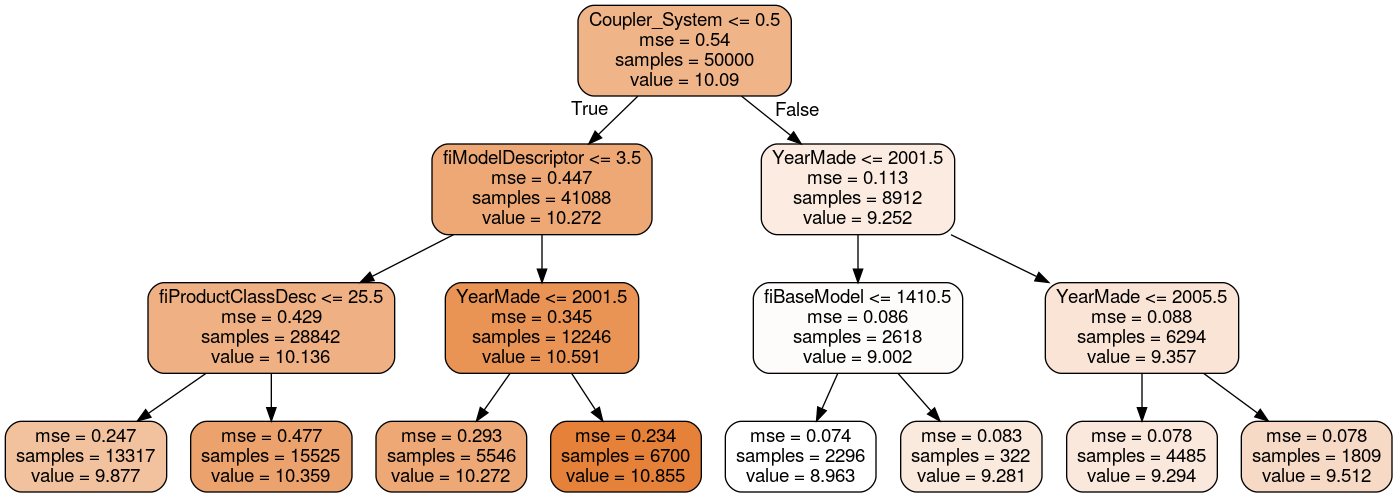

In [171]:
# Export the tree to a graphviz 'dot' format
from sklearn.tree import export_graphviz
from IPython import display

str_tree = export_graphviz(m.estimators_[0],
                           out_file='tree.dot',
                           feature_names=x_df.columns,
                           filled=True,
                           rounded=True)

# Convert 'dot' to 'png'
!dot -Tpng 'tree.dot' -o 'tree.png'

# Show image
from IPython.display import Image
Image(filename='tree.png') 

TypeError: 'module' object is not callable